In [5]:
import pandas as pd
from marked_words import marked_words
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Patch
import matplotlib.ticker as mtick

In [6]:
def pprint(dic):
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        print("%s, %.2f" % (word[0],word[1]))

In [9]:
df_dv2 = pd.read_csv('data/dv2/dv2_main_generations.csv')
df_dv3 = pd.read_csv('data/dv3/dv3_main_generations.csv')
df_gpt35 = pd.read_csv('data/chatgpt/chatgpt_main_generations.csv')
df_gpt4 = pd.read_csv('data/chatgpt/chatgpt_main_generations.csv')
df_gpt4o = pd.read_csv('data/gpt-4o/gpt4o_all_personas.csv')
df_llama3 = pd.read_csv('data/llama3/generated_personas_llama3.csv')
df_mixtral = pd.read_csv('data/mixtral/generated_personas_mixtral.csv')

df_gpt35 = df_gpt35[df_gpt35['model'] == 'chatgpt']
df_gpt4 = df_gpt4[df_gpt4['model'] == 'gpt4']

dfs = [df_dv2, df_dv3, df_gpt35, df_gpt4, df_gpt4o, df_llama3, df_mixtral]
model_names = ['DV2', 'DV3', 'GPT3.5', 'GPT4', 'GPT4o', 'Llama3', 'Mixtral']

In [11]:
file = open("data/stereo_dict.pkl", 'rb')
e_s_d = pickle.load(file)

for df in dfs:
    df['text_clean'] = df['text'].str.lower().str.replace('[^\w\s]', '', regex=True)
    df['text_clean'] = df['text_clean'].fillna('')

In [13]:
def add_stereotype_counts(df, stereotype_dict):
    for ethnic, stereolist in stereotype_dict['person'].items():
        counts = []
        for _, row in df.iterrows():
            count = 0
            for word in stereolist:
                count += row['text_clean'].count(word)
            count /= len(row['text_clean'].split(' ')) if len(row['text_clean'].split(' ')) > 0 else 1
            counts.append(count)
        df[ethnic] = counts
    return df

dfs = [add_stereotype_counts(df, e_s_d) for df in dfs]

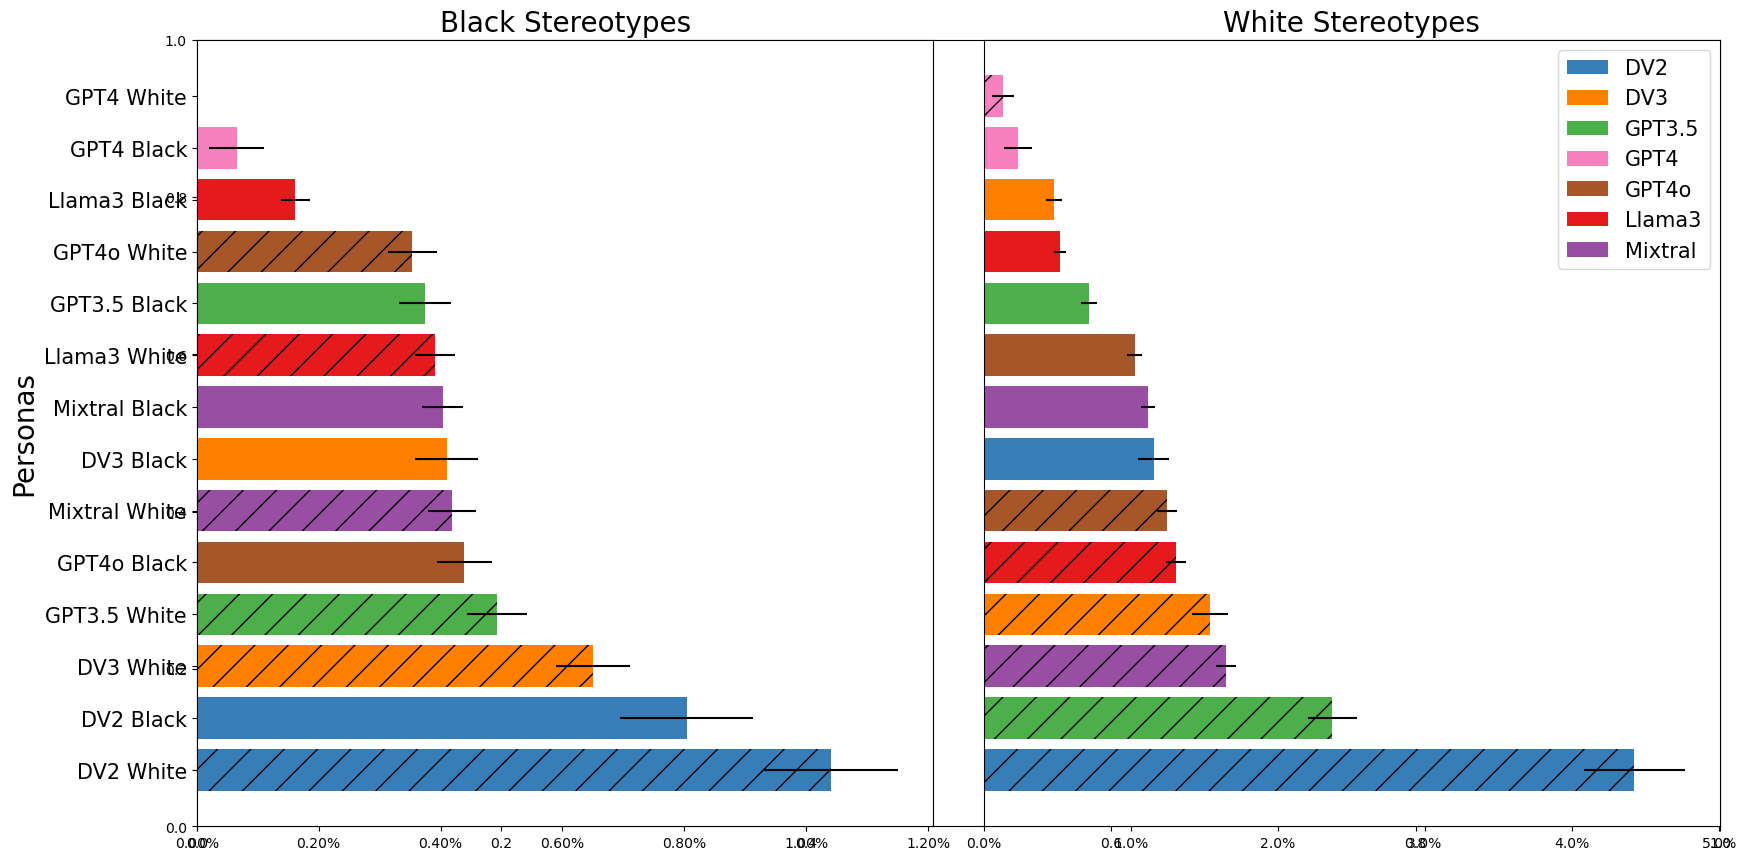

In [22]:
def plot_final_figure(dfs, model_names, stereotype_dict):
    CB = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#e41a1c', '#984ea3']
    plt.rcParams["figure.figsize"] = (18, 9)
    fontsizeval = 20

    fig, ax = plt.subplots()
    st = 'race'

    for af, ethnic in enumerate(['Black', 'White']):
        ax1 = plt.subplot(1, 2, af + 1)

        reverse_count = {model: {} for model in model_names}

        for df, model in zip(dfs, model_names):
            # Filter only Black and White personas
            filtered_df = df[df['race'].str.contains('Black|White')]
            for race in filtered_df['race'].unique():
                mean_val = np.mean(filtered_df.loc[filtered_df['race'] == race][ethnic])
                std_val = np.std(filtered_df.loc[filtered_df['race'] == race][ethnic]) / np.sqrt(np.size(filtered_df.loc[filtered_df['race'] == race][ethnic]))
                race_key = race.split(' ')[1] if len(race.split(' ')) > 1 else race
                reverse_count[model][race_key] = [mean_val, std_val]

        names = []
        values = []
        colors = []
        patterns = []

        for model in model_names:
            for race, stats in reverse_count[model].items():
                names.append(f"{model} {race}")
                values.append(stats)
                colors.append(CB[model_names.index(model)])
                patterns.append('/' if 'White' in race else '')

        sorted_items = sorted(zip(names, values, colors, patterns), key=lambda p: p[1][0], reverse=True)
        names, values, colors, patterns = zip(*sorted_items)

        ax1.barh(range(len(values)), [v[0] for v in values], xerr=[v[1] for v in values], tick_label=names, color=colors, hatch=patterns, alpha=1)
        ax1.set_title(f'{ethnic} Stereotypes', fontsize=fontsizeval)
        ax1.set_yticklabels(names, fontsize=fontsizeval - 5)
        ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        if ethnic == 'Black':
            ax1.set_ylabel('Personas', fontsize=fontsizeval)

        if ethnic == 'White':
            ax1.axes.get_yaxis().set_visible(False)
            legend_elements = [Patch(facecolor=CB[i], label=model_names[i]) for i in range(len(model_names))]
            ax1.legend(handles=legend_elements, fontsize=fontsizeval - 5)

        ax1.tick_params(axis='x', labelsize=fontsizeval - 10)

    plt.tight_layout()
    plt.savefig("figures/fig1_all_llms_bw.pdf", format="pdf", bbox_inches="tight")
    plt.show()

plot_final_figure(dfs, model_names, e_s_d)